![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Aprendizaje por transferencia

En este notebook usará  modelos previamente entrenados para la detección de rostros y la predicción de edad y genero, es decir usará aprendizaje por transferencia o *transfer learning*.

## Instrucciones Generales

Este notebook usará inicialmente la librería [MTCNN](https://github.com/ipazc/mtcnn) para detectar rostros en una imagen, y posteriormente reutilizará el modelo VGGFace para predecir la edad y el genero de los rostros. En el siguente paper puede conocer más detalles del modelo VGGFace: *Qawaqneh, Z., Mallouh, A. A., & Barkana, B. D. (2017). Deep convolutional neural network for age estimation based on VGG-face model. arXiv preprint arXiv:1709.01664.*. https://arxiv.org/abs/1709.01664
  
Para realizar la actividad, solo siga las indicaciones asociadas a cada celda del notebook. 

## Importar imagenes y librerías

In [1]:
# Importación librerías
from matplotlib import pyplot
from PIL import Image
from numpy import asarray

In [2]:
import os
os.chdir('..')

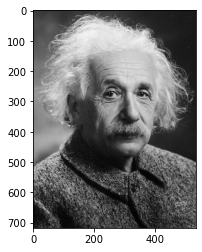

In [8]:
filename = "images/face_1.JPG"
pixels = pyplot.imread(filename)
pyplot.imshow(pixels)

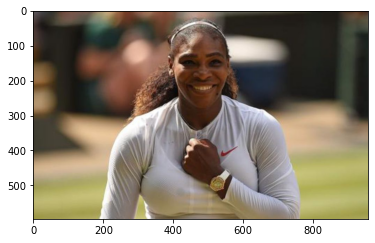

In [10]:
filename = "images/face_2.jpg"
pixels = pyplot.imread(filename)
pyplot.imshow(pixels)

## Extraer rostro de una imagen

Para ejecutar esta sección del código debe instalar la librería MTCNN con el comando *!pip install mtcnn*

In [6]:
# Importación detector de rostros
from mtcnn.mtcnn import MTCNN

# Definición detector de rostros
detector = MTCNN()
results = detector.detect_faces(pixels)
results

[{'box': [165, 96, 144, 199],
  'confidence': 0.999996542930603,
  'keypoints': {'left_eye': (199, 175),
   'right_eye': (271, 175),
   'nose': (234, 218),
   'mouth_left': (203, 245),
   'mouth_right': (271, 245)}}]

In [7]:
# Función para extraer rostros
def get_face(img):
    # Carga de imagen
    pixels = pyplot.imread(img)
    results = detector.detect_faces(pixels)
    # Extracción del rosto
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    # Reescalar imagen a tamaño específico
    required_size=(224, 224)
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    # Retornar rostro
    return face_array

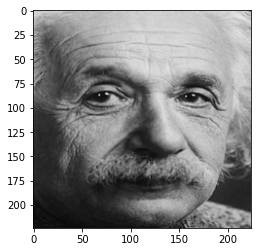

In [8]:
img1 = get_face('images/face_1.jpg')
pyplot.imshow(img1)

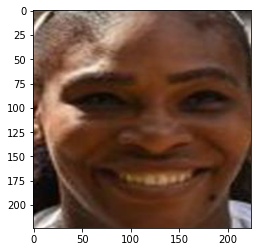

In [9]:
img2 = get_face('images/face_2.jpg')
pyplot.imshow(img2)

## Generar embbeding (vector) para cada rostro

Para ejecutar esta sección del código deben instalar la siguiente librería *!pip install keras_vggface*

In [15]:
from keras_vggface.vggface import VGGFace
import numpy as np

# Definición modelo vggface
model = VGGFace(model='resnet50')

# impresión de tamaño de inputs y outputs
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_5')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


In [16]:
# Predicción embedding del modelo para rostro 1
yhat1 = model.predict(img1[np.newaxis,:,:,:])
print(yhat1.shape)
yhat1

(1, 8631)


array([[2.1525145e-06, 9.2734888e-07, 8.3095993e-06, ..., 2.3632145e-05,
        5.0733644e-05, 1.0955352e-05]], dtype=float32)

In [19]:
# Predicción embedding del modelo para rostro 2
yhat2 = model.predict(img2[np.newaxis,:,:,:])
print(yhat2.shape)
yhat2

(1, 8631)


array([[1.05502245e-07, 6.46735202e-07, 1.04210915e-06, ...,
        4.21402910e-05, 2.24422115e-06, 3.05320032e-06]], dtype=float32)

## Predecir genero y edad

Para ejecutar esta sección del código debe instalar la librería omegaconf con el comando *!pip install omegaconf* 

In [20]:
# Importación librerías
from tensorflow.keras import applications
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from omegaconf import OmegaConf
from pathlib import Path
WEIGHTS_FILE = 'datasets/EfficientNetB3_224_weights.11-3.44.hdf5'
model_name, img_size = Path(WEIGHTS_FILE).stem.split("_")[:2]
cfg = OmegaConf.from_dotlist([f"model.model_name={model_name}", f"model.img_size={img_size}"])

In [21]:
# Definición modelo
def get_model(cfg):
    base_model = getattr(applications, cfg.model.model_name)(
        include_top=False,
        input_shape=(cfg.model.img_size, cfg.model.img_size, 3),
        pooling="avg"
    )
    features = base_model.output
    # Capa adicional para predicción de genero
    pred_gender = Dense(units=2, activation="softmax", name="pred_gender")(features)
    # Capa adicional para predicción de edad
    pred_age = Dense(units=101, activation="softmax", name="pred_age")(features)
    model = Model(inputs=base_model.input, outputs=[pred_gender, pred_age])
    return model

In [33]:
# Cargar modelo con set de parámetros
model = get_model(cfg)
model.load_weights(WEIGHTS_FILE)

In [34]:
# Predicciónes del modelo imagen 1
results = model.predict(img1[np.newaxis,:,:,:])

In [35]:
# Predicciones imagen 1
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()
predicted_genere = 'hombre' if (results[0][0][1] >= 0.5) else 'mujer'

print('Edad imagen 1: ', predicted_ages)
print('Genero imagen 1: ', predicted_genere)

Edad imagen 1:  [54.62701012]
Genero imagen 1:  hombre


In [36]:
# Predicciónes del modelo imagen 2
results = model.predict(img2[np.newaxis,:,:,:])

In [37]:
# Predicciones imagen 2
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()
predicted_genere = 'hombre' if (results[0][0][1] >= 0.5) else 'mujer'

print('Edad imagen 1: ', predicted_ages)
print('Genero imagen 1: ', predicted_genere)

Edad imagen 1:  [32.80568726]
Genero imagen 1:  mujer
